## Import Package

In [5]:
# required packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba as nb
import warnings
from datetime import datetime
import gc
# Machine Learning
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)
sns.set_style('whitegrid')
pd.options.display.max_rows = 999

## Load Data

In [6]:
# Functions for memory reduction
@nb.jit()
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return(df)

In [8]:
%%time
# Read DataFrames from CSV file
prop_2016 = pd.read_csv('data/prop_2016.csv')
prop_2016 = reduce_mem_usage(prop_2016)

prop_2017 = pd.read_csv('data/prop_2017.csv')
prop_2017 = reduce_mem_usage(prop_2017)

train = pd.read_csv('data/train.csv')
train = reduce_mem_usage(train)

Mem. usage decreased to 725.97 Mb (65.4% reduction)
Mem. usage decreased to 720.27 Mb (65.6% reduction)
Mem. usage decreased to 39.71 Mb (67.7% reduction)
CPU times: user 1min 40s, sys: 54.4 s, total: 2min 35s
Wall time: 2min 42s


In [9]:
def drop_features(df):
    """
    Drop id columns and columns not needed.
    """
    # id and label (not features)
    drop_list = ['parcelid']
    
    # Too many Missing Values from EDA
    drop_list.extend(['architecturalstyletypeid','buildingclasstypeid',
                      'decktypeid','typeconstructiontypeid'])
    
    # Duplicated Columns found from EDA
    drop_list.extend(['calculatedbathnbr','finishedsquarefeet50'])
    
    # Highly Correlated with other related columns
    drop_list.extend(['fullbathcnt','censustractandblock'])
    
    # Drop columns with low feature importance
    drop_list.extend(['fireplaceflag','fips','finishedsquarefeet13','poolsizesum','pooltypeid10','basementsqft',
                     'storytypeid','yardbuildingsqft26','finishedsquarefeet6','fireplacecnt','regionidcounty',
                      'propertyzoningdesc','propertycountylandusecode'])

    return(df.drop(columns=drop_list))

In [10]:
def encoding(train, prop_2016, prop_2017, categorical_features):
    """
    To limit the value to small numbers since values in categorical_feature is suggested to be small.
    Now the number denoting missing values will be 0 instead of -1.
    """
    from sklearn.preprocessing import LabelEncoder
    
    prop = pd.concat([train[categorical_features],
                      prop_2016[categorical_features], 
                      prop_2017[categorical_features]], ignore_index=True)
    
    for col in categorical_features:
        encoder = LabelEncoder().fit(prop[col].astype(str))
        train[col] = encoder.transform(train[col].astype(str))
        prop_2016[col] = encoder.transform(prop_2016[col].astype(str))
        prop_2017[col] = encoder.transform(prop_2017[col].astype(str))
    del prop
    gc.collect()
    return(train, prop_2016, prop_2017)

In [11]:
# Do encoding for cateogircal features
categorical_features = ['airconditioningtypeid','buildingqualitytypeid',
                        'hashottuborspa','heatingorsystemtypeid','pooltypeid2','pooltypeid7',
                        'propertylandusetypeid','rawcensustractandblock',
                        'regionidcity','regionidneighborhood','regionidzip', 'yearbuilt','assessmentyear',
                        'taxdelinquencyflag','taxdelinquencyyear','geo_cluster']

train, prop_2016, prop_2017 = encoding(train, prop_2016, prop_2017, categorical_features)

# Transform to Numpy matrices
X = drop_features(train).drop(columns='logerror')
y = train.logerror.values

# Specify feature names
feature_names = [col for col in X.columns]

# Get categorical features
categorical_indices = []
for i, n in enumerate(X.columns):
    if n in categorical_features:
        categorical_indices.append(i)

# Perform shuffled train/test split
np.random.seed(910)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Keep outlier values (roughly outside 99% percentile) out of the training dataset
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train.iloc[mask, :]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (131489, 73)
y_train shape: (131489,)
X_test shape: (33578, 73)
y_test shape: (33578,)


## Parameter Tuning

In [12]:
from sklearn.metrics import mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from lightgbm import LGBMRegressor

In [18]:
param_lgb= {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 20, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',5,50,1)),
    'subsample': hp.quniform('subsample', 0.2, 1, 0.1),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0)}

In [19]:
def tuning_hyperparam_lgb(X, y, num_eval, metric = mean_absolute_error, param = param_lgb):
    """
    Wrapper Function for the entire bayesian hyperparameter tuning process. 
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # tuning hyperparameter
    print("Tuning hyperparameter for the output model.")
    t = datetime.now()
    results_hyperopt = hyperopt(param, X_train, y_train, X_test, y_test, num_eval)
    
    # Retrieve Hyperopt scores
    hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
    hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
    
    # plotting
    plot_learning_curve(hyperopt_scores, num_eval = num_eval)
    
    # retrieve best results
    best = results_hyperopt.best_trial['misc']['vals']
    
    clf = LGBMRegressor(learning_rate=np.float(best['learning_rate'][0]), 
                        max_depth=np.int(best['max_depth'][0]),
                        num_leaves=np.int(best['num_leaves'][0]), 
                        boosting_type='gbdt', 
                        colsample_bytree=np.float(best['colsample_by_tree'][0]), 
                        min_child_samples=np.int(best['min_child_samples'][0]),
                        subsample = np.float(best['subsample'][0]),
                        reg_lambda=np.float(best['reg_lambda'][0]),
                        reg_alpha=np.float(best['reg_alpha'][0]),
                        n_jobs=4)
    print("Complete.")
    print(f"Time used: {datetime.now() - t}")
    print("")
    return(clf)

In [20]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    """
    Main hyperparameter tuning function.
    """
    start = time.time()
    
    def objective_function(params):
        clf = LGBMRegressor(**params).fit(X_train, y_train)
        pred = clf.predict(X_test)
        return {'loss': mean_absolute_error(y_test, pred), 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))    
    return(trials)

In [21]:
def plot_learning_curve(hyperopt_scores, num_eval):
    """
    Plot hyperparameter learning curve.
    """
    f, ax = plt.subplots(figsize=(7,6))
    sns.set_palette("husl")
    sns.despine()
    ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
    plt.title("Finding the optimum", fontsize=18)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
    plt.legend(loc='lower right', labels=['Hyperopt'])
    plt.setp(ax.get_legend().get_texts(), fontsize='12')

Tuning hyperparameter for the output model.
100%|██████████| 300/300 [17:10<00:00,  3.43s/it, best loss: 0.05188630499974799]
Complete.
Time used: 0:17:10.432212



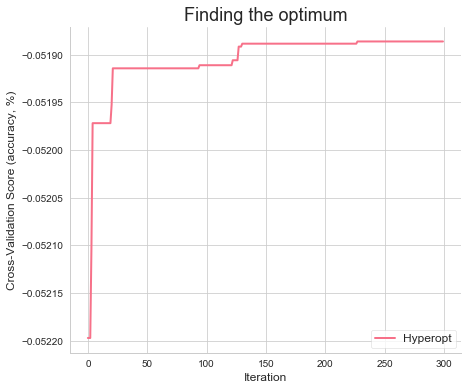

In [22]:
clf = tuning_hyperparam_lgb(X_train, y_train, num_eval=300)

In [32]:
params = clf.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6283,
 'importance_type': 'split',
 'learning_rate': 0.0100,
 'max_depth': 17,
 'min_child_samples': 48,
 'min_child_weight': 0.0010,
 'min_split_gain': 0.0000,
 'n_estimators': 100,
 'n_jobs': 4,
 'num_leaves': 141,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.3328,
 'reg_lambda': 3.7644,
 'silent': True,
 'subsample': 0.3000,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [33]:
# Add more parameters
params['objective'] = 'regression'
params['metric'] = 'mae'
params['n_estimators'] = 5000
params['num_threads'] = 4
params['min_data'] = 150
params['sub_feature'] = 0.5 
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0

In [35]:
%%time

# Train LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, 
                        categorical_feature=categorical_features,
                       free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test, feature_name=feature_names, 
                       categorical_feature=categorical_features,
                      free_raw_data=False)

np.random.seed(910)
model = lgb.train(params, lgb_train, verbose_eval=200, early_stopping_rounds=200,
                valid_sets=[lgb_train, lgb_test], valid_names=['train', 'test'],
                categorical_feature=categorical_indices)

# Evaluate on train and validation sets
print(f"Train score: {abs(model.predict(X_train) - y_train).mean() * 100}")
print(f"Test score: {abs(model.predict(X_test) - y_test).mean() * 100}")

Training until validation scores don't improve for 200 rounds
[200]	train's l1: 0.0504727	test's l1: 0.0689291
[400]	train's l1: 0.0493556	test's l1: 0.069014
Early stopping, best iteration is:
[205]	train's l1: 0.0504322	test's l1: 0.0689269
Train score: 5.043216846605548
Test score: 6.892692635385374
CPU times: user 1min 1s, sys: 785 ms, total: 1min 1s
Wall time: 18.3 s


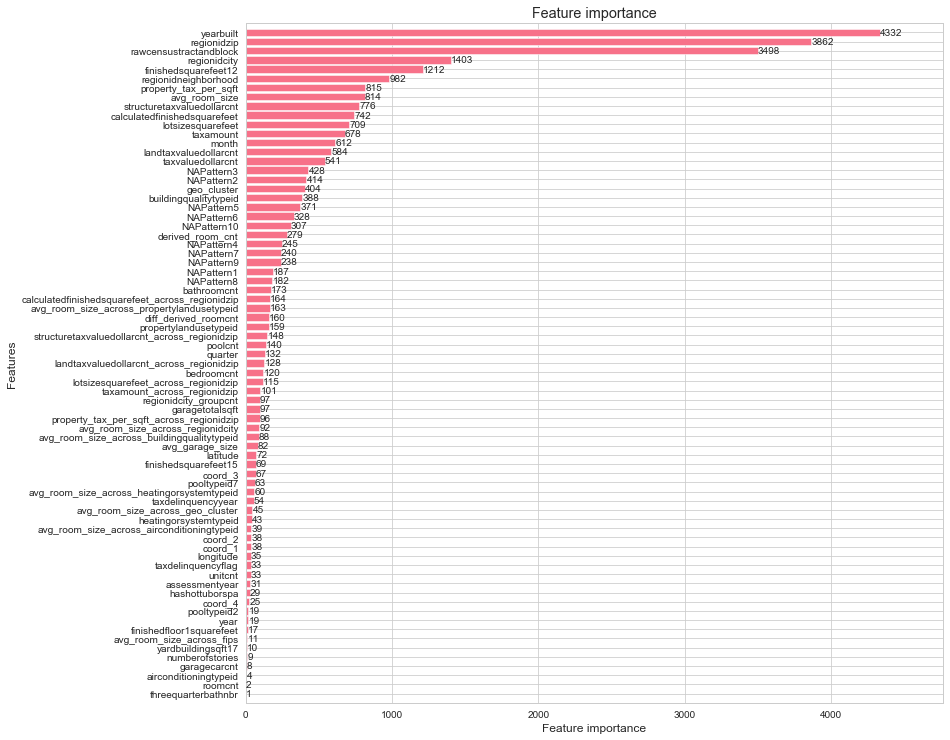

In [36]:
# Plot LightGBM feature importance
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

## Training on all Data

In [38]:
# Train LightGBM on all given training data (preparing for submission)
params['n_estimators'] = 10000

outlier_threshold = 0.4
mask = (abs(y) <= outlier_threshold)
X = X.iloc[mask, :]
y = y[mask]

lgb_training_set = lgb.Dataset(X, label=y, feature_name=feature_names,
                              categorical_feature=categorical_features,
                              free_raw_data=False)

# Train multiple models
iters = 5
models = []
for i in range(iters):
    print(f"Start training model {i}")
    params['seed'] = i
    model = lgb.train(params, lgb_training_set, early_stopping_rounds=200,
                      valid_sets=[lgb_training_set, lgb_test], valid_names=['All', 'test'],
                      verbose_eval=200, categorical_feature=categorical_indices)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print(f"model {i}: {abs(model.predict(X_test) - y_test).mean() * 100}")

Start training model 0
Training until validation scores don't improve for 200 rounds
[200]	All's l1: 0.0506148	test's l1: 0.0675535
[400]	All's l1: 0.0496204	test's l1: 0.0665325
[600]	All's l1: 0.0488564	test's l1: 0.065768
[800]	All's l1: 0.0482107	test's l1: 0.0651632
[1000]	All's l1: 0.0476161	test's l1: 0.0645915
[1200]	All's l1: 0.0470938	test's l1: 0.0641014
[1400]	All's l1: 0.0466012	test's l1: 0.0636085
[1600]	All's l1: 0.0461458	test's l1: 0.0631571
[1800]	All's l1: 0.0457077	test's l1: 0.0627375
[2000]	All's l1: 0.0452954	test's l1: 0.0623446
[2200]	All's l1: 0.044883	test's l1: 0.0619524
[2400]	All's l1: 0.0444996	test's l1: 0.0615906
[2600]	All's l1: 0.0441221	test's l1: 0.0612211
[2800]	All's l1: 0.0437626	test's l1: 0.0608615
[3000]	All's l1: 0.0434176	test's l1: 0.0605325
[3200]	All's l1: 0.0430773	test's l1: 0.0601739
[3400]	All's l1: 0.0427546	test's l1: 0.0598551
[3600]	All's l1: 0.0424243	test's l1: 0.0595258
[3800]	All's l1: 0.0421073	test's l1: 0.0592339
[4000]	Al

[2000]	All's l1: 0.0453043	test's l1: 0.0623389
[2200]	All's l1: 0.0448995	test's l1: 0.0619594
[2400]	All's l1: 0.0445109	test's l1: 0.0615892
[2600]	All's l1: 0.0441393	test's l1: 0.061249
[2800]	All's l1: 0.0437857	test's l1: 0.0608951
[3000]	All's l1: 0.0434298	test's l1: 0.0605462
[3200]	All's l1: 0.0430898	test's l1: 0.0602223
[3400]	All's l1: 0.0427512	test's l1: 0.0598893
[3600]	All's l1: 0.0424232	test's l1: 0.0595696
[3800]	All's l1: 0.0420944	test's l1: 0.0592496
[4000]	All's l1: 0.0417841	test's l1: 0.0589368
[4200]	All's l1: 0.0414844	test's l1: 0.0586448
[4400]	All's l1: 0.0411794	test's l1: 0.0583506
[4600]	All's l1: 0.0408887	test's l1: 0.0580621
[4800]	All's l1: 0.0406018	test's l1: 0.0578038
[5000]	All's l1: 0.0403252	test's l1: 0.057517
[5200]	All's l1: 0.0400437	test's l1: 0.0572602
[5400]	All's l1: 0.0397775	test's l1: 0.0569937
[5600]	All's l1: 0.0395157	test's l1: 0.0567372
[5800]	All's l1: 0.0392485	test's l1: 0.0564806
[6000]	All's l1: 0.0389932	test's l1: 0.05

In [39]:
def transform_test_features(prop_2016, prop_2017):
    """
    Helper method that prepares prop_2016 and prop_2017 for prediction.
    """
    prop_2016 = drop_features(prop_2016)
    prop_2017 = drop_features(prop_2017)
    
    # Create three datetime columns that does not exist in those dataset
    prop_2016['year'] = 0
    prop_2017['year'] = 1
    
    prop_2016['month'] = 8 # randomly select one month
    prop_2017['month'] = 8 # randomly select one month
    
    prop_2016['quarter'] = 3 # randomly select one quarter
    prop_2017['quarter'] = 3 # randomly select one quarter
    
    # Reorder to maintain categorical indices
    prop_2016 = prop_2016[['year', 'month', 'quarter'] + list(prop_2016.columns[:-3])]
    prop_2017 = prop_2017[['year', 'month', 'quarter'] + list(prop_2017.columns[:-3])]
    return(prop_2016, prop_2017)

def predict_and_export(models, prop_2016, prop_2017, file_name):
    """
    Helper method to make predicition and export results to csv.
    """
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid
    
    # Prepare dataset for prediction
    prop_2016, prop_2017 = transform_test_features(prop_2016, prop_2017)
    
    # Make Prediction across multiple models
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(prop_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(prop_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    # Formatting for submission
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = pd.merge(submission_2016,submission_2017, how='inner', on='ParcelId')
    submission.to_csv(file_name, index=False)
    print("Submission Successfully Created.")
    return(submission, pred_2016, pred_2017)

In [ ]:
%%time
del train, lgb_test, lgb_train, lgb_training_set
gc.collect()

file_name = 'submission/final_lgb2.csv'
submission, pred_2016, pred_2017 = predict_and_export(models, prop_2016, prop_2017, file_name)

Start model 0 (2016)
